# Drought Prediction

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import pickle

In [3]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import NearMiss

## Data Wrangling

#### Reading the input data

In [4]:
# drought_df_train = pd.read_csv('data/train_timeseries.csv')
# drought_df_test = pd.read_csv('data/test_timeseries.csv')
# drought_df_test = pd.read_csv('data/validation_timeseries.csv')

drought_df =  pd.read_csv('data/all_timeseries.csv')
drought_df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,year,month,day
0,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,2.08,3.59,6.73,9.31,3.74,5.58,1,2000,1,4
1,1001,2000-01-11,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,...,1.05,1.43,3.55,6.38,1.71,4.67,2,2000,1,11
2,1001,2000-01-18,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,...,1.67,1.92,5.19,6.40,3.84,2.55,2,2000,1,18
3,1001,2000-01-25,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,...,2.28,2.32,5.75,8.03,3.96,4.07,2,2000,1,25
4,1001,2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,...,0.88,1.86,4.18,6.38,1.27,5.11,1,2000,2,1


In [5]:
drought_df.columns

Index(['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score', 'year', 'month', 'day'],
      dtype='object')

In [14]:
soil_df = pd.read_csv('data/soil_data.csv')

## Data Eng

In [7]:
# Function to filter outliers based on the 3-sigma rule
def remove_outliers(df, columns):
    """
    Remove outliers from the specified columns in a DataFrame using the 3-sigma rule.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns (list of str): The list of columns to apply the outlier removal.
    
    Returns:
    pd.DataFrame: The DataFrame with outliers removed.
    """
    for col in columns:
        # Calculate the mean and standard deviation for the current column
        mean = df[col].mean()
        std = df[col].std()

        # Calculate the upper and lower limits using the 3-sigma rule
        upper_limit = mean + 3 * std
        lower_limit = mean - 3 * std

        # Filter the DataFrame to exclude rows where the column value is outside the 3-sigma limits
        df = df[(df[col] <= upper_limit) & (df[col] >= lower_limit)]
    return df

In [8]:
# Avoiding Categorical cols
measures = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']

# Remove outliers
cleaned_drought_df = remove_outliers(drought_df, measures)

# Print the number of rows before and after removing outliers
print(f'Total rows before removing outliers: {len(drought_df)}')
print(f'Total rows after removing outliers: {len(cleaned_drought_df)}')
print(f'Number of outliers: {len(drought_df)-len(cleaned_drought_df)}')

Total rows before removing outliers: 3403260
Total rows after removing outliers: 3054658
Number of outliers: 348602


In [10]:
# Combine timeseries and soil data
combined_df = cleaned_drought_df.merge(soil_df, how='left', on='fips')

# Drop fips code and date
combined_df.drop(columns=['fips','date'], inplace=True)

# List columns
combined_df.columns

Index(['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
       'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE',
       'score', 'year', 'month', 'day', 'lat', 'lon', 'elevation', 'slope1',
       'slope2', 'slope3', 'slope4', 'slope5', 'slope6', 'slope7', 'slope8',
       'aspectN', 'aspectE', 'aspectS', 'aspectW', 'aspectUnknown', 'WAT_LAND',
       'NVG_LAND', 'URB_LAND', 'GRS_LAND', 'FOR_LAND', 'CULTRF_LAND',
       'CULTIR_LAND', 'CULT_LAND', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6',
       'SQ7'],
      dtype='object')

In [11]:
# Split to X,y train,test
X_train, X_test, y_train, y_test = train_test_split(combined_df.drop(columns=['score']), combined_df['score'], test_size=0.2, random_state=42)   

print("Train features shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test features shape", X_test.shape)
print("Test target shape", y_test.shape)

Train features shape (2443726, 52)
Train target shape (2443726,)
Test features shape (610932, 52)
Test target shape (610932,)


#### Standardizing the data

In [12]:
# Standardizing features by to mean and scaling to unit variance
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) # Fit the scaler on the training data and transform the training data
X_test = scaler.transform(X_test)       # Transform the test data using the fitted scaler

In [21]:
# Save the scaler object to a file
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

#### Fixing class imbalance

In [22]:
# Upsampling using SMOTE (Synthetic Minority Over-sampling Technique)

sm = SMOTE(random_state = 1) # Instance of the SMOTE class

# Apply SMOTE to the training data
X_train_ures_SMOTE, y_train_ures_SMOTE = sm.fit_resample(X_train, y_train.to_numpy())

In [23]:
print('Before OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_train_ures_SMOTE.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_ures_SMOTE.shape))

print("Counts of label '0' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 0),sum(y_train_ures_SMOTE == 0)))
print("Counts of label '1' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 1),sum(y_train_ures_SMOTE == 1)))
print("Counts of label '2' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 2),sum(y_train_ures_SMOTE == 2)))
print("Counts of label '3' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 3),sum(y_train_ures_SMOTE == 3)))
print("Counts of label '4' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 4),sum(y_train_ures_SMOTE == 4)))
print("Counts of label '5' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 5),sum(y_train_ures_SMOTE == 5)))

Before OverSampling, the shape of train_X: (2443726, 52)
Before OverSampling, the shape of train_y: (2443726,) 

After OverSampling, the shape of train_X: (9103362, 52)
After OverSampling, the shape of train_y: (9103362,) 

Counts of label '0' - Before Oversampling:1517227, After OverSampling: 1517227
Counts of label '1' - Before Oversampling:412980, After OverSampling: 1517227
Counts of label '2' - Before Oversampling:249363, After OverSampling: 1517227
Counts of label '3' - Before Oversampling:155322, After OverSampling: 1517227
Counts of label '4' - Before Oversampling:79514, After OverSampling: 1517227
Counts of label '5' - Before Oversampling:29320, After OverSampling: 1517227


#### PCA

In [24]:
pca = PCA()     # Instance of the PCA class

X_train_ures_SMOTE_PCAreduced = pca.fit_transform(X_train_ures_SMOTE)   # Fit PCA on the upsampled training data and transform it
X_test_SMOTE_PCA_transformed = pca.transform(X_test)                    # Transform the test data using the fitted PCA

In [41]:
# Save the PCA object to a file
with open('pca_model.pkl', 'wb') as file:
    pickle.dump(pca, file)

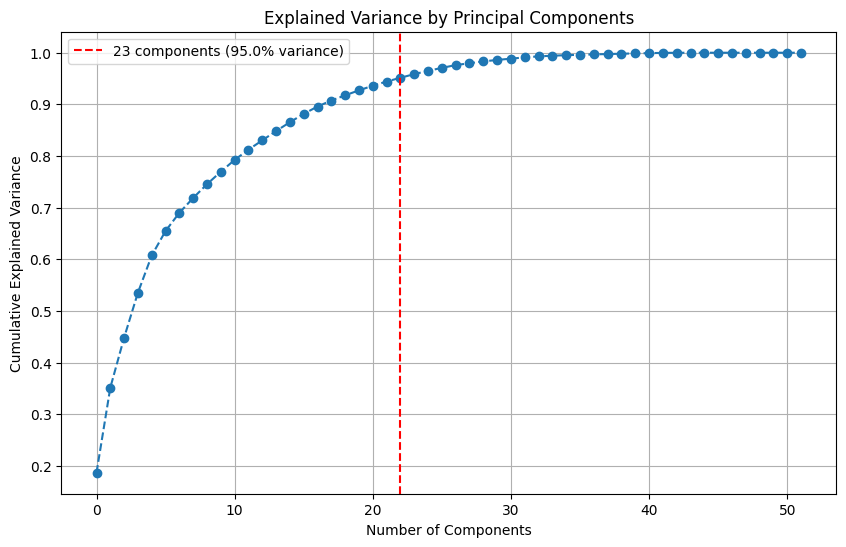

In [32]:
# Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine number of components that explain 95% of variance
threshold = 0.95
num_components = np.argmax(cumulative_variance >= threshold) + 1

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()

# Add vertical line for num_components
plt.axvline(x=num_components - 1, color='r', linestyle='--', label=f'{num_components} components ({threshold * 100:.1f}% variance)')
plt.legend()

plt.show()

In [27]:
print(f"X_train Shape: {X_train_ures_SMOTE_PCAreduced.shape}")
print(f"y_train Shape: {y_train_ures_SMOTE.shape}")

print(f"X_test  Shape: {X_test_SMOTE_PCA_transformed.shape}")
print(f"y_test  Shape: {y_test.shape}")

X_train Shape: (9103362, 52)
y_train Shape: (9103362,)
X_test  Shape: (610932, 52)
y_test  Shape: (610932,)


In [25]:
# Saving the objects:
with open('data\Xy_trainTest.pkl', 'wb') as f:  
    pickle.dump([X_train_ures_SMOTE_PCAreduced, X_test_SMOTE_PCA_transformed, 
                 y_train_ures_SMOTE, y_test], f)

In [ ]:
# Getting back the objects:
with open('data\Xy_trainTest.pkl', 'rb') as f:  
    X_train, X_test, y_train, y_test = pickle.load(f)

# FOR MODEL INPUTS

In [50]:
def format_input_for_model(input_series, scaler_file='scaler.pkl', pca_model_file='pca_model.pkl'):
    # Step 1: Merge input_series with soil_df based on 'fips'
    soil_df = pd.read_csv('data/soil_data.csv')
    input_data = pd.DataFrame(input_series).T.merge(soil_df, on='fips', how='left')
    
    # Step 2: Drop unnecessary columns 'date' and 'fips' if they exist
    input_data.drop(columns=['date', 'fips'], inplace=True, errors='ignore')
    
    # Step 3: Load the saved StandardScaler object
    with open(scaler_file, 'rb') as file:
        scaler = pickle.load(file)
    
    # Step 4: Scale the input data
    scaled_data = scaler.transform(input_data)
    
    # Step 5: Load the saved PCA object and apply transformation
    with open(pca_model_file, 'rb') as file:
        pca_model = pickle.load(file)
    
    pca_transformed = pca_model.transform(scaled_data)
    
    return pca_transformed

In [51]:
# Example usage:
input_series = drought_df.drop(columns=['score']).iloc[0]  # Example input data
formatted_input = format_input_for_model(input_series)

# Display input_series and formatted_input
print("Input Series:")
print(input_series)
print("\nFormatted Input After Preprocessing:")
print(formatted_input)
print("\nShapes:")
print(f"Input Series Shape: {input_series.shape}")
print(f"Formatted Input Shape: {formatted_input.shape}")

Input Series:
fips                 1001
date           2000-01-04
PRECTOT             15.95
PS                 100.29
QV2M                 6.42
T2M                  11.4
T2MDEW               6.09
T2MWET                6.1
T2M_MAX             18.09
T2M_MIN              2.16
T2M_RANGE           15.92
TS                  11.31
WS10M                3.84
WS10M_MAX            5.67
WS10M_MIN            2.08
WS10M_RANGE          3.59
WS50M                6.73
WS50M_MAX            9.31
WS50M_MIN            3.74
WS50M_RANGE          5.58
year                 2000
month                   1
day                     4
Name: 0, dtype: object

Formatted Input After Preprocessing:
[[ 7.04522582e-01 -2.92456168e-01 -6.33846229e-01 -1.02320858e+00
   1.09296898e+00  3.05310122e-01 -9.57448849e-02  1.70161112e+00
  -1.86575326e+00  1.42976851e+00  3.25090609e+00  4.10658237e-01
  -9.35472833e-01 -1.49237342e+00 -1.56141952e+00 -1.11877206e-01
  -1.56664738e+00  1.40051927e+00  6.68006002e-01  6.59365594e-